In [1]:
import pandas as pd
import geopandas as gpd

# Visualizing damage to buildings in the Gaza Strip

```{note}
The results shown in this analysis only reflect the damages until October 25th 2023. As the team completes further analysis, the notebook will be updated. 
```


In [236]:
# read aggregated damage assessment files
damage_assessment_totals = pd.read_excel('../../data/damaga_assessment/Gaza_damage_25Oct.xlsx')
damage_assessment_totals.rename(columns = {'Unnamed: 0': 'ADM2_EN'}, inplace=True)
damage_assessment_buildings = pd.read_excel('../../data/damaga_assessment/Gaza_damage_25Oct.xlsx', sheet_name = 'Buildings')
damage_assessment_buildings.rename(columns = {'Unnamed: 0': 'ADM2_EN'}, inplace=True)

damage_assessment_pois = pd.read_excel('../../data/damaga_assessment/Gaza_damage_25Oct.xlsx', sheet_name = 'POIS')
damage_assessment_pois.rename(columns = {'Unnamed: 0': 'ADM2_EN'}, inplace=True)

damage_assessment_roads = pd.read_excel('../../data/damaga_assessment/Gaza_damage_25Oct.xlsx', sheet_name = 'Roads')
damage_assessment_roads.rename(columns = {'Unnamed: 0': 'ADM2_EN'}, inplace=True)


In [6]:
# read shapefiles
palestine = gpd.read_file('../../data/shapefiles/pse_adm_pamop_20231019_shp/pse_admbnda_adm1_pamop_20231019.shp')
gaza = palestine[palestine['ADM1_EN']=='Gaza Strip']
gaza_adm2 = gpd.read_file('../../data/shapefiles/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp')

In [11]:
damage_assessment_buildings_gpd = gpd.read_file('../../data/damaga_assessment/delivery1_16Nov2023/delivery1_16Nov2023/vectors/buildings_Gaza_damaged_until_25Oct2023_AvgAreaDamaged_MaxHeight.shp')
damage_assessment_poi_gpd = gpd.read_file('../../data/damaga_assessment/delivery1_16Nov2023/delivery1_16Nov2023/vectors/pois_damaged_changeTotal_mean_max.shp')
damage_assessment_roads_gpd = gpd.read_file('../../data/damaga_assessment/delivery1_16Nov2023/delivery1_16Nov2023/vectors/roads_Gaza_3857_100m_damaged_intersected.shp')

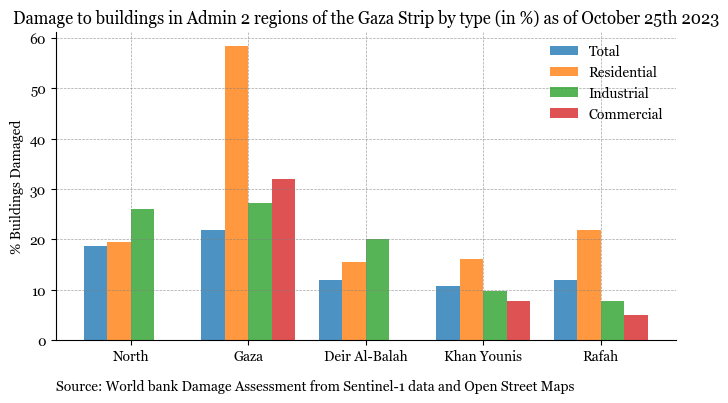

In [208]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Georgia"


df = damage_assessment_buildings.set_index('ADM2_EN')[['%', '%.1', '%.2', '%.3']][0:5]
df.rename(columns = {'%':'Total', '%.1':'Residential', '%.2':'Industrial', '%.3':'Commercial'}, inplace=True)

df1 = df.stack().reset_index()
df1.rename(columns = {'level_1':'damage_type', 0:'damage_percentage'}, inplace=True)

fig, ax = plt.subplots(figsize=(8,4))

# Number of groups and categories
n_groups = df1['ADM2_EN'].nunique()
n_categories = df1['damage_type'].nunique()

# Bar parameters
bar_width = 0.2
opacity = 0.8
index = np.arange(n_groups)

# Plotting bars for each category
for i, category in enumerate(df1['damage_type'].unique()):
    category_values = df1[df1['damage_type'] == category]['damage_percentage'].values
    ax.bar(index + i * bar_width, category_values, bar_width, alpha=opacity, label=category)

# Add labels and customization
ax.set_ylabel('% Buildings Damaged')
ax.set_xticks(index + bar_width * (n_categories - 1) / 2)

ax.set_xticklabels(df1['ADM2_EN'].unique())
ax.legend(frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

ax.set_title('Damage to buildings in Admin 2 regions of the Gaza Strip by type (in %) as of October 25th 2023', font = 'Georgia', fontsize=12)

subtitle = 'Source: World bank Damage Assessment from Sentinel-1 data and Open Street Maps'
ax.text(0, -0.15, subtitle, ha='left', va='center', transform=ax.transAxes,
        fontsize=10, color='black', weight='normal');


In [180]:
def get_poi_classification(poi):
    if poi in [ 'School', 'School_dam', 'College',
       'College_dam', 'Uni', 'Uni_dam', 'Kindergarden', 'Kinder_dam']:
        return 'Educational Institutions'
    elif poi.lower() in ['mall ',
       'mall_dam', 'market_place', 'market_dam', 'department_store',
       'dep_damage']:
        return 'Places of Economic Activity'
    elif poi.lower() in ['water_tower', 'water_dam']:
        return 'Water Infrastructure'
    else:
        return 'Communications Infrastructure'

In [118]:
def get_damage_columns(x):
    if 'dam' in x.lower():
        return 'Damage'
    else:
        return 'Total'

In [209]:
damage_assessment_pois = damage_assessment_pois[0:5]

In [213]:
df = damage_assessment_pois.set_index('ADM2_EN').stack().reset_index()
df.rename(columns = {'level_1':'building_type', 0:'number'}, inplace=True)
df['building_category'] = df['building_type'].apply(lambda x: get_poi_classification(x))
df['value_type'] = df['building_type'].apply(lambda x: get_damage_columns(x))

df = df.groupby(['ADM2_EN', 'building_category', 'value_type']).sum().reset_index().pivot_table(index = ['ADM2_EN', 'building_category'], columns = 'value_type').reset_index()

multi_index = pd.MultiIndex.from_tuples([
    ('ADM2_EN', ''),
    ('building_category', ''),
    ('number', 'Damage'),
    ('number', 'Total')
], names=[None, 'value_type'])
new_columns = [f'{x[0]}_{x[1]}' if x[1] else f'{x[0]}' for x in multi_index]

df.columns = new_columns
df['percentage_damage'] = 100*df['number_Damage']/df['number_Total']

df1 = df

df = df[['ADM2_EN','building_category', 'percentage_damage']].pivot_table(index='ADM2_EN', columns = 'building_category', values='percentage_damage').reset_index()


In [237]:
damage_assessment_roads = damage_assessment_roads[0:5]
damage_assessment_roads['%.2'].replace({'na':0}, inplace=True)

,ADM2_EN,Roads (km),damaged roads,%,tracks,damaged tracks,%.1,primary,damaged primary,%.2,secondary,damaged secondary,%.3
0,North,1118.86,249.10,22.26,282.75,7.01,2.48,0.50,0.29,58.45,58.28,23.84,40.91
1,Gaza,1732.87,450.68,26.01,429.85,13.01,3.03,27.56,8.33,30.23,180.34,61.71,34.22
2,Deir Al-Balah,1358.85,179.42,13.20,433.39,17.66,4.07,0.00,0.00,na,22.14,1.80,8.15
3,Khan Younis,2078.70,233.76,11.25,540.30,15.44,2.86,0.00,0.00,na,78.76,12.47,15.83
4,Rafah,1258.89,179.63,14.27,355.90,14.33,4.03,4.88,0.25,5.14,64.28,15.11,23.51


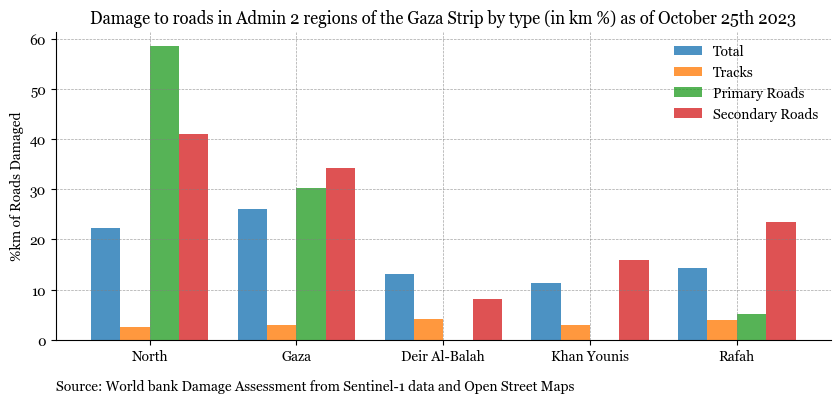

In [241]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Georgia"


df = damage_assessment_roads.set_index('ADM2_EN')[['%', '%.1', '%.2', '%.3']][0:5]
df.rename(columns = {'%':'Total', '%.1':'Tracks', '%.2':'Primary Roads', '%.3':'Secondary Roads'}, inplace=True)

df1 = df.stack().reset_index()
df1.rename(columns = {'level_1':'damage_type', 0:'damage_percentage'}, inplace=True)

fig, ax = plt.subplots(figsize=(10,4))

# Number of groups and categories
n_groups = df1['ADM2_EN'].nunique()
n_categories = df1['damage_type'].nunique()

# Bar parameters
bar_width = 0.2
opacity = 0.8
index = np.arange(n_groups)

# Plotting bars for each category
for i, category in enumerate(df1['damage_type'].unique()):
    category_values = df1[df1['damage_type'] == category]['damage_percentage'].values
    ax.bar(index + i * bar_width, category_values, bar_width, alpha=opacity, label=category)

# Add labels and customization
ax.set_ylabel('%km of Roads Damaged')
ax.set_xticks(index + bar_width * (n_categories - 1) / 2)

ax.set_xticklabels(df1['ADM2_EN'].unique())
ax.legend(frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

ax.set_title('Damage to roads in Admin 2 regions of the Gaza Strip by type (in km %) as of October 25th 2023', font = 'Georgia', fontsize=12)

subtitle = 'Source: World bank Damage Assessment from Sentinel-1 data and Open Street Maps'
ax.text(0, -0.15, subtitle, ha='left', va='center', transform=ax.transAxes,
        fontsize=10, color='black', weight='normal');


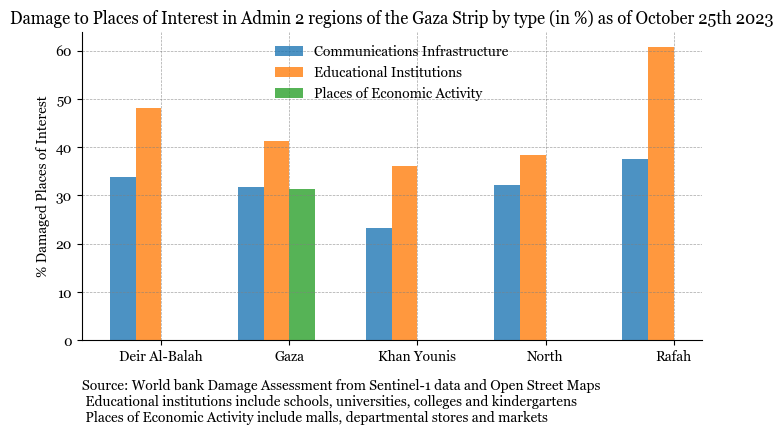

In [218]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Georgia"


fig, ax = plt.subplots(figsize=(8,4))

# Number of groups and categories
n_groups = df1['ADM2_EN'].nunique()
n_categories = df1['building_category'].nunique()

# Bar parameters
bar_width = 0.2
opacity = 0.8
index = np.arange(n_groups)

# Plotting bars for each category
for i, category in enumerate(['Communications Infrastructure', 'Educational Institutions',
       'Places of Economic Activity']):
    category_values = df1[df1['building_category'] == category]['percentage_damage'].values
    ax.bar(index + i * bar_width, category_values, bar_width, alpha=opacity, label=category)

# Add labels and customization
ax.set_ylabel('% Damaged Places of Interest')
ax.set_xticks(index + bar_width * (n_categories - 1) / 2)

ax.set_xticklabels(df1['ADM2_EN'].unique())
ax.legend(frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

ax.set_title('Damage to Places of Interest in Admin 2 regions of the Gaza Strip by type (in %) as of October 25th 2023', font = 'Georgia', fontsize=12)

subtitle = 'Source: World bank Damage Assessment from Sentinel-1 data and Open Street Maps \n Educational institutions include schools, universities, colleges and kindergartens \n Places of Economic Activity include malls, departmental stores and markets'
ax.text(0, -0.2, subtitle, ha='left', va='center', transform=ax.transAxes,
        fontsize=10, color='black', weight='normal');


### Damage Map

You can now interact with this map by selecting/deselecting different damage layers to visualize where buildings are most impacted in the Gaza Strip

<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/26ba3dfb-0770-4cc6-b6fa-2ee2878580fc/embed" frameborder="0" allowfullscreen></iframe>